In [2]:
!nvidia-smi

Fri Feb 25 04:10:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7

     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
     |████████████████████████████████| 3.3 MB 12.2 MB/s 
     |████████████████████████████████| 830 kB 5.4 MB/s 
     |████████████████████████████████| 829 kB 38.8 MB/s 
     |████████████████████████████████| 134 kB 44.0 MB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
     |████████████████████████████████| 397 kB 45.8 MB/s 
     |████████████████████████████████| 1.1 MB 35.2 MB/s 
     |████████████████████████████████| 271 kB 47.1 MB/s 
     |████████████████████████████████| 144 kB 47.4 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 


In [4]:
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [5]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

In [6]:
pl.seed_everything(42)

Global seed set to 42


42

In [7]:
!gdown --id 1tv6CHJ46apilYI4465AeX7f6qr60UsHG

Downloading...
From: https://drive.google.com/uc?id=1tv6CHJ46apilYI4465AeX7f6qr60UsHG
To: /content/news_summary.csv.zip
100% 4.32M/4.32M [00:00<00:00, 118MB/s]


In [8]:
!unzip -q news_summary.csv.zip -d data

In [9]:
df=pd.read_csv("data/news_summary.csv",encoding="latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [10]:
df=df[["text","ctext"]]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [11]:
df.columns=["summary" , "text"]
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [12]:
df.shape

(4396, 2)

In [13]:
train_df,test_df=train_test_split(df,test_size=0.1)
train_df.shape,test_df.shape

((3956, 2), (440, 2))

In [14]:
from pandas.core.internals.managers import T
class NewsSummaryDataset(Dataset):
  def __init__(
      self,
      data:pd.DataFrame,
      tokenizer: T5Tokenizer,
      text_max_token_len : int =512,
      summary_max_token_len : int =128
  ):
    self.tokenizer=tokenizer
    self.data=data
    self.text_max_token_len= text_max_token_len
    self.summary_max_token_len=summary_max_token_len

  def __len__(self):
    return len(self.data)
  def __getitem__(self,index:int):
    data_row = self.data.iloc[index]
    text=data_row["text"]
    text_encoding=tokenizer(text,
        max_length=self.text_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    summary_encoding=tokenizer(
        data_row["summary"],
        max_length=self.summary_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    labels=summary_encoding["input_ids"]
    labels[labels==0]=-100
    return dict(
        text=text,
        summary= data_row["summary"],
        text_input_ids = text_encoding["input_ids"].flatten(),
        text_attention_mask=text_encoding["attention_mask"].flatten(),
        labels=labels.flatten(),
        labels_attention_mask = summary_encoding["attention_mask"].flatten()
    )



In [15]:
class NewsSummaryDataModule(pl.LightningDataModule):

  def __init__(
      self,
      train_df:pd.DataFrame,
      test_df:pd.DataFrame,
      tokenizer:T5Tokenizer,
      batch_size: int =4,
      text_max_token_len:int=512,
      summary_max_token_len:int=128
  ):
    super().__init__()
    self.train_df=train_df
    self.test_df=test_df
    self.tokenizer=tokenizer
    self.batch_size=batch_size
    self.text_max_token_len=text_max_token_len
    self.summary_max_token_len=summary_max_token_len

  def setup(self,stage=None):
    self.train_dataset=NewsSummaryDataset(
    self.train_df,
    self.tokenizer,
    self.text_max_token_len,
    self.summary_max_token_len
    )
    self.test_dataset=NewsSummaryDataset(
    self.test_df,
    self.tokenizer,
    self.text_max_token_len,
    self.summary_max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        
    )



In [16]:
MODEL_NAME="t5-base"
tokenizer=T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [17]:
text_token_counts,summary_token_counts=[],[]
for _,row in train_df.iterrows():
  text_token_count=len(tokenizer.encode(row["text"]))
  text_token_counts.append(text_token_count)
  summary_token_count=len(tokenizer.encode(row["summary"]))
  summary_token_counts.append(summary_token_count)


Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'Summary text token counts')

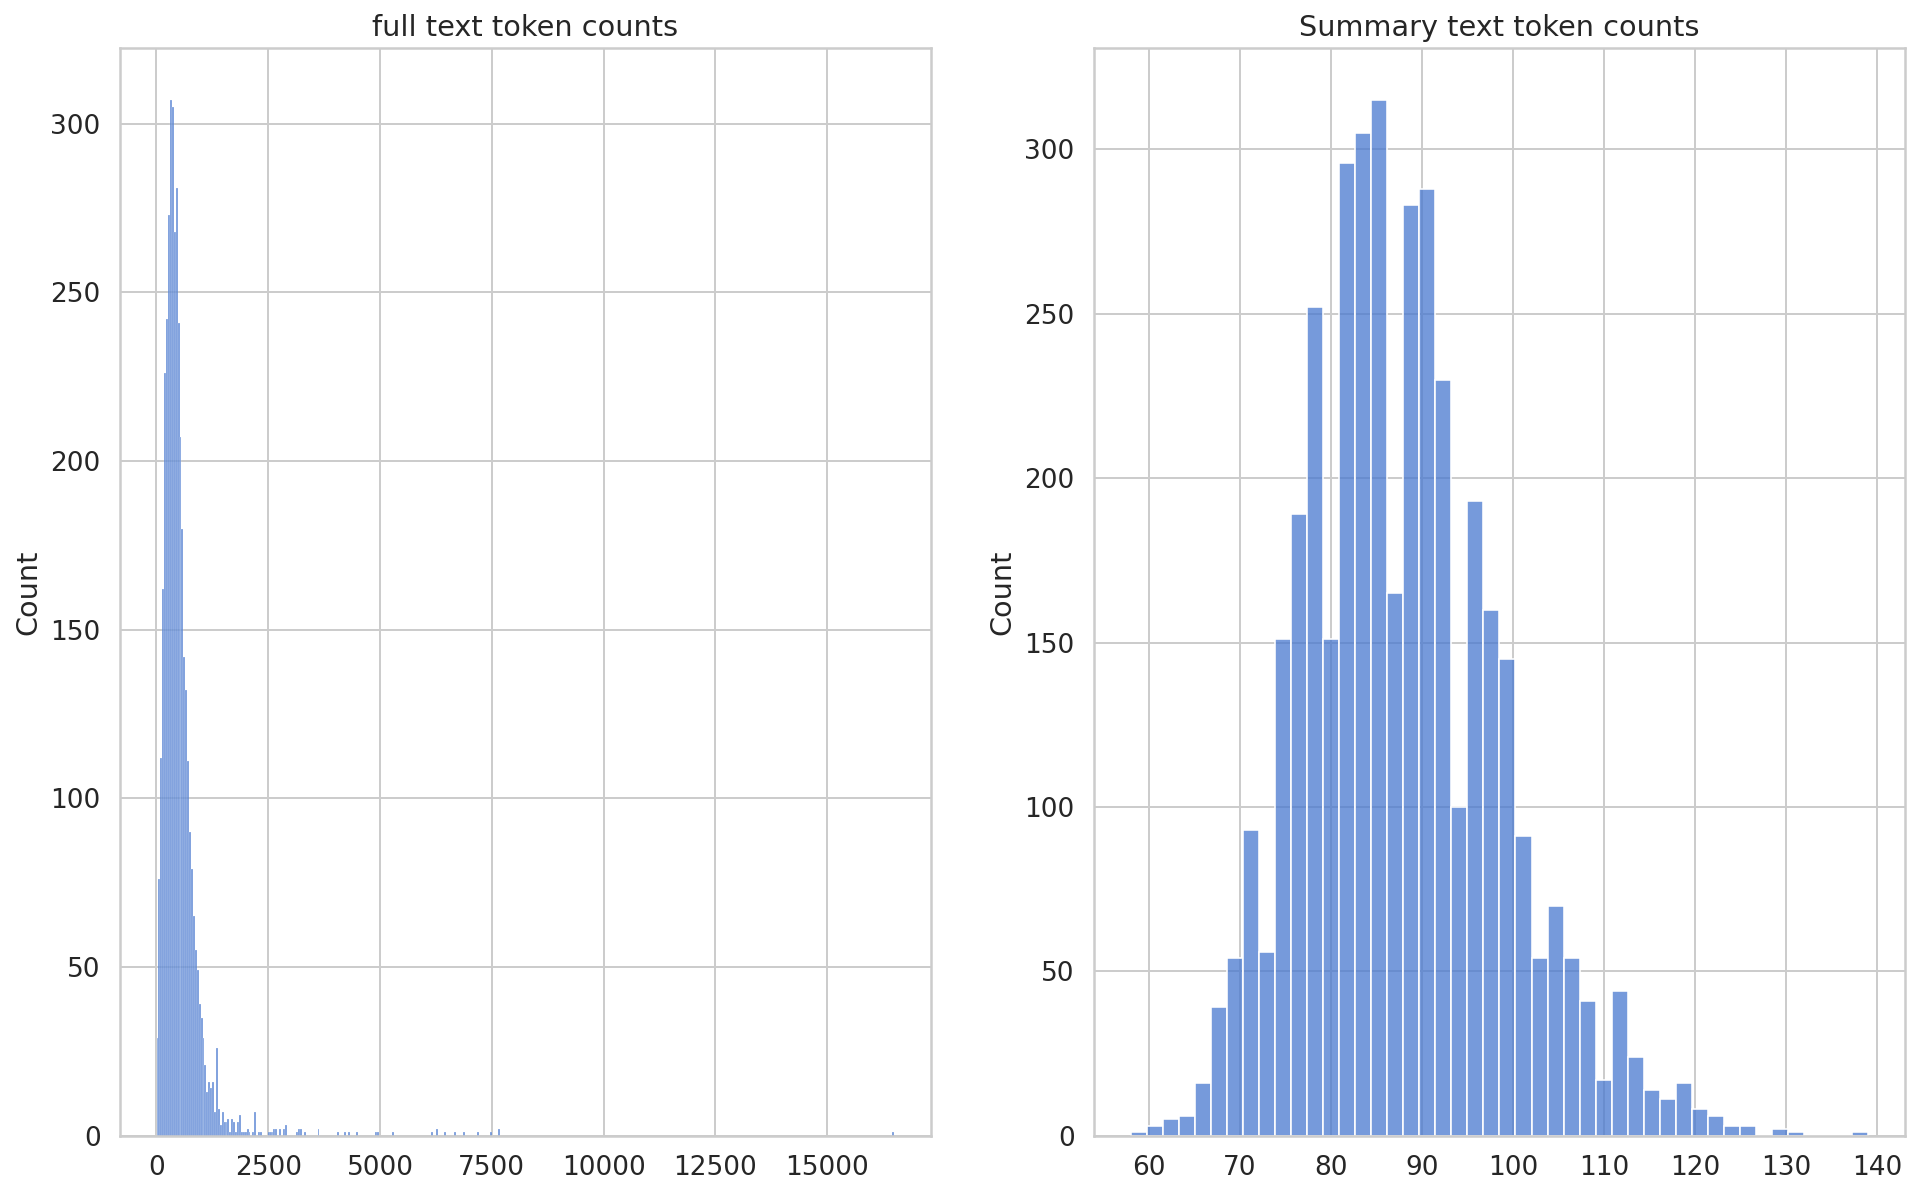

In [18]:
fig ,(ax1,ax2)=plt.subplots(1,2)
sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("full text token counts")
sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Summary text token counts")

In [19]:
N_EPOCHS=3
BATCH_SIZE=4
data_module=NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

In [20]:
class NewsSummaryModel(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.model=T5ForConditionalGeneration.from_pretrained(MODEL_NAME,return_dict=True)
  def forward(self,input_ids,attention_mask,decoder_attention_mask,labels=None):

    output=self.model(
        input_ids,
        attention_mask=attention_mask,
        labels=labels,
        decoder_attention_mask=decoder_attention_mask
    )
    return output.loss,output.logits

  def training_step(self,batch,batch_idx):
    input_ids=batch["text_input_ids"]
    attention_mask=batch["text_attention_mask"]
    labels=batch["labels"]
    labels_attention_mask=batch["labels_attention_mask"]
    loss,outputs= self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )
    self.log("train_loss",loss,prog_bar=True,logger=True)
    return loss

  def test_step(self,batch,batch_idx):
      input_ids=batch["text_input_ids"]
      attention_mask=batch["text_attention_mask"]
      labels=batch["labels"]
      labels_attention_mask=batch["labels_attention_mask"]
      loss,outputs= self(
          input_ids=input_ids,
          attention_mask=attention_mask,
          decoder_attention_mask=labels_attention_mask,
          labels=labels
      )
      self.log("test_loss",loss,prog_bar=True,logger=True)
      return loss

  def configure_optimizers(self):
      return AdamW(self.parameters(),lr=0.0001)

In [21]:
model=NewsSummaryModel()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [22]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

In [23]:
checkpoint_callback=ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="train_loss",
    mode="min"
)
logger=TensorBoardLogger("lightening_logs",name="news-summary")
trainer=pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30,
    
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [24]:
trainer.fit(model,data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 988: train_loss reached 1.70168 (best 1.70168), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 1, global step 1977: train_loss reached 1.48153 (best 1.48153), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 2, global step 2966: train_loss reached 1.36407 (best 1.36407), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


1

In [25]:
trained_model=NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

In [26]:
def summarize(text):
  text_encoding=tokenizer(
      text,
      max_length=512,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
  )

  generated_ids=trained_model.model.generate(
      input_ids=text_encoding["input_ids"],
      attention_mask=text_encoding["attention_mask"],
      max_length=150,
      num_beams=2,
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True
  )

  preds=[
         tokenizer.decode(gen_id,skip_special_tokens=True,clean_up_tokenization_spaces=True)
         for gen_id in generated_ids
  ]

  return "".join(preds)

In [27]:
sample_row=test_df.iloc[2]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [28]:
text

'Continuing a yearly tradition, outgoing US President Barack Obama signed a proclamation to declare January 16 Religious Freedom Day. "Religious freedom is a principle based not on shared ancestry, culture, ethnicity, or faith but on a shared commitment to liberty - and it lies at the very heart of who we are as Americans," Obama said on Friday.Each year, by Presidential Proclamation, January 16 is declared Religious Freedom Day in the US.Obama urged the country\'s citizens to reject politics that seeks to target people because of their religion."Part of being American means guarding against bigotry and speaking out on behalf of others, no matter their background or belief - whether they are wearing a hijab or a baseball cap, a yarmulke or a cowboy hat," he said.The president said America\'s strength comes from its diversity."And we must be unified in our commitment to protecting the freedoms of conscience and religious belief and the freedom to live our lives according to them," he sa

In [29]:
sample_row["summary"]

'US President Barack Obama has declared January 16 as Religious Freedom Day in accordance with a yearly tradition. Urging his countrymen to stand against religious intolerance, Obama said, "religious freedom is a principle based not on shared ancestry, culture, ethnicity, or faith but on a shared commitment to liberty." He further said that America\'s strength comes from its diversity.'

In [30]:
model_summary

'Outgoing US President Barack Obama on Friday signed a proclamation to declare January 16 as Religious Freedom Day. "Religious freedom is a principle based not on shared ancestry, culture, ethnicity, or faith but on a shared commitment to liberty - and it lies at the very heart of who we are as Americans," Obama said.'

In [31]:
sample_row=test_df.iloc[31]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [32]:
text

'The trailer of Akshay Kumar and Bhumi Pednekar\'s Toilet: Ek Prem Katha has been lauded by one and all, including Prime Minister Narendra Modi. But there is one person who is not impressed. Filmmaker Praveen Vyas has sent a legal notice and a cease and desist notice for the film\'s trailer and promotional campaign, Mumbai Mirror reports.Praveen Vyas, whose 2016 docu-feature Manini also revolves around the Swachh Bharat Abhiyan, has alleged that several scenes and dialogues Akshay and Bhumi\'s film are a direct copy of his documentary. "Manini follows the female protagonist as she protests against lack of a toilet in her marital home on the first night of her marriage after female relatives wake her up before sunrise to tend to nature\'s call in an open field. The scenes in Toilet: Ek Prem Katha\'s trailer shows the same interaction between characters," the filmmaker told the publication.His film beat thousands of entries centred on the theme of Swachh Bharat to win the third prize at 

In [33]:
sample_row["summary"]

'Filmmaker Praveen Vyas has sent a legal notice to the makers of \'Toilet- Ek Prem Katha\', accusing them of copying his 2016 documentary Manini. "Since they\'ve...refused to monetarily compensate us for the origin of idea and script, we will now be fighting this in court," said Vyas. Toilet Ek Prem Katha is a take on PM Modi\'s Swachh Bharat Abhiyan. '

In [34]:
model_summary

'Filmmaker Praveen Vyas has sent a legal notice and cease and desist notice for the trailer of Akshay Kumar\'s film \'Toilet: Ek Prem Katha\'. "Manini follows the female protagonist as she protests against lack of a toilet in her marital home on the first night of her marriage after female relatives wake her up before sunrise to tend to nature\'s call in an open field," said Vyas.'

In [35]:
sample_row=test_df.iloc[55]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [36]:
text

'More than half of the languages spoken by India\'s 1.3 billion people may die out over the next 50 years, scholars said on Thursday, calling for a concerted effort to preserve the tongues spoken by the nation\'s endangered tribal communities.The People\'s Linguistic Survey of India (PSLI) raised the alarm during the launch of the latest 11 volumes in its planned 50 volume survey of the country\'s languages. India\'s people speak as many as 780 different languages, the PSLI said."At least 400 Indian languages are at the risk of dying in coming 50 years," GN Devy, the chairman of PSLI, said.Each time a language is lost, the corresponding culture is killed, Devy said, adding that India had already lost 250 languages in last five decades.The group of scholars and teachers at PSLI documents Indian regional languages in order to conserve cultural heritage and diversity.Most at risk are marginal tribal communities whose children receive no education or, if they do go to school, are taught in

In [37]:
sample_row["summary"]

'At least 400 languages or more than half languages spoken by India\'s 1.3 billion people may die out in next 50 years, a study by the People\'s Linguistic Survey of India (PSLI) stated. Further claiming that India has already lost 250 languages in last five decades, the survey said, "Each time a language is lost, the corresponding culture is killed."'

In [38]:
model_summary

"More than half of the languages spoken by India's 1.3 billion people may die out over the next 50 years, scholars said on Thursday. The People's Linguistic Survey of India (PSLI) raised the alarm during the launch of the latest 11 volumes in its planned 50-volume survey of the country's languages."

In [39]:
sample_row=test_df.iloc[121]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [40]:
text

'Box-office clashes have become inevitable in the recent past. From Dilwale and Bajirao Mastani to Ae Dil Hai Mushkil and Shivaay to Raees and Kaabil, Bollywood saw some of the biggest films take on each other at the ticket windows recently. And now fans are gearing up for another big clash. This time Akshay Kumar\'s Toilet Ek Prem Katha will fight it out with Shah Rukh Khan\'s next with Imtiaz Ali at the box office. And this has raised expectations and tension. But Khiladi Kumar, who has been in the industry for over two decades now, is unfazed by the clash. In an interview to BollywoodLife.com, Akshay said, "Tell me a guy who doesn\'t have a clash? Clash is going to happen. There are 180 films that release every year and how many weeks are there? Nearly 52. Clash is bound to happen." \xa0This is not the first time that Akshay\'s film is facing competition at the box office. Last year, Rustom clashed with Hrithik Roshan\'s Mohenjo Daro, and passed the test with flying colours. The 49-

In [41]:
sample_row["summary"]

'Actor Akshay Kumar has said that a clash is bound to happen, when asked about the same release date for his film Toilet: Ek Prem Katha and Shah Rukh Khan\'s yet untitled film with Imtiaz Ali. "Tell me a guy who doesn\'t have a clash? Clash is going to happen. There are 180 films that release every year," added Akshay. '

In [42]:
model_summary

'Actor Khiladi Kumar has said that there are 180 films that release every year and how many weeks are there? Nearly 52. "Tell me a guy who doesn\'t have a clash? Clash is going to happen," added Akshay. Toilet Ek Prem Katha will be released on August 11 this year. The film stars Bhumi Pednekar alongside Akshay.'

In [43]:
sample_row=test_df.iloc[2]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [44]:
text

'Continuing a yearly tradition, outgoing US President Barack Obama signed a proclamation to declare January 16 Religious Freedom Day. "Religious freedom is a principle based not on shared ancestry, culture, ethnicity, or faith but on a shared commitment to liberty - and it lies at the very heart of who we are as Americans," Obama said on Friday.Each year, by Presidential Proclamation, January 16 is declared Religious Freedom Day in the US.Obama urged the country\'s citizens to reject politics that seeks to target people because of their religion."Part of being American means guarding against bigotry and speaking out on behalf of others, no matter their background or belief - whether they are wearing a hijab or a baseball cap, a yarmulke or a cowboy hat," he said.The president said America\'s strength comes from its diversity."And we must be unified in our commitment to protecting the freedoms of conscience and religious belief and the freedom to live our lives according to them," he sa

In [45]:
sample_row["summary"]

'US President Barack Obama has declared January 16 as Religious Freedom Day in accordance with a yearly tradition. Urging his countrymen to stand against religious intolerance, Obama said, "religious freedom is a principle based not on shared ancestry, culture, ethnicity, or faith but on a shared commitment to liberty." He further said that America\'s strength comes from its diversity.'

In [46]:
model_summary

'Outgoing US President Barack Obama on Friday signed a proclamation to declare January 16 as Religious Freedom Day. "Religious freedom is a principle based not on shared ancestry, culture, ethnicity, or faith but on a shared commitment to liberty - and it lies at the very heart of who we are as Americans," Obama said.'

In [47]:
sample_row=test_df.iloc[281]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [48]:
text

'From Prasoon Srivastava Barcelona, Mar 2 (PTI) The governments proposal to auction spectrum every year has got a backer in Bharti Airtel Chairman Sunil Bharti Mittal, who however has said there is no need for sale of airwaves in coming fiscal. "The way he (telecom secretary) has put it that spectrum auction will be done every year whether industry needs it or not is very progressive thought. In fact, it will become a leading edge practice worldwide," Mittal told PTI in an interview. J S Deepak, as the Telecom Secretary, a couple of days ago said the government is looking at making spectrum auction an annual event and will reach out to sector regulator Trai for its recommendations. He had said the government plans to provide industry with an option to buy spectrum every year irrespective of their interest so that there is never a shortage of spectrum in providing quality mobile services. Deepak, a 1982-batch IAS officer from Uttar Pradesh, who at present is at the World Mobile Congress

In [49]:
sample_row["summary"]

'Bharti Airtel Chairman Sunil Mittal has said the government\'s proposal to auction spectrum every year whether industry needs it or not is "very progressive thought". "In fact, it will become a leading edge practice worldwide," Mittal added. Earlier, Telecom Secretary JS Deepak said the government is looking to make spectrum auction an annual event and will seek TRAI\'s recommendations.'

In [50]:
model_summary

'Bharti Airtel Chairman Sunil Mittal has said there is no need for sale of airwaves in the coming fiscal. "The way he (telecom secretary) has put it that spectrum auction will be done every year whether industry needs it or not is very progressive thought," Mittal added. Mittal further said that even though telecom operators are bleeding with the entrance of a new service provider, they will need to increase investment in networks to handle competition.'

In [52]:
sample_row=test_df.iloc[111]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [53]:
text

'Even as Assam reels under floods a Comptroller and Auditor General (CAG) report revealed a shortfall of 60% in the release of central funds for the state?s flood management projects.The centre was supposed to release R. 2,043.19 crore between 2007-08 and 2015-16 for 141 projects but only released R. 812.22 crore. The state government fared worse, releasing only 16% of the allocated budget provision. ?Insufficient flow of fund adversely affected the implementation of schemes,? the CAG report concluded.In Assam 14 districts have been inundated with floods, over 2 lakh people are displaced and over 70 people have lost their lives, in this year alone. Floods are a natural phenomena in these areas because excessive monsoon rains cause flooding regularly, but shoddy preparedness has only made the situation worse.?There were huge delays in completion of River Management Activities and Works related to Border Areas projects which were long term solutions for the flood problems of Assam, North

In [54]:
sample_row["summary"]

'There has been a 60% shortfall in the release of central funds to Assam for flood management, according to a Comptroller and Auditor General report. The centre was supposed to release over ?2,000 crore between 2007-08 and 2015-16 but provided only ?812 crore. It further added that the state government released only 16% of the allocated budget for flood management.'

In [55]:
model_summary

"A Comptroller and Auditor General (CAG) report has revealed a shortfall of 60% in the release of central funds for Assam's flood management projects. The Centre was supposed to release?2,043.19 crore between 2007-08 and 2015-16 for 141 projects but only released?812.22 crore. The state government fared worse, releasing only 16% of the allocated budget provision."

In [57]:
sample_row=test_df.iloc[213]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [58]:
text

'Tiger Shroff has stayed away from any negative stories around him, ever since he started his career in Bollywood  in 2014. However, the actor?s recent comment, where he allegedly referred to his Student of the Year 2 co-stars as ?padding?, didn?t go down well with people and he was trolled on social media.Although Tiger did clarify his stance on this, talking to us recently, he again picked on the subject and shared his views. ?I don?t understand why people these days overreact unnecessarily on everything that an actor says. I used ?padding? so casually and got badly scr**ed. It?s so funny how using one wrong word can screw up your career,? says Tiger.    Hope you are ready to hit the streets, #DingDang will be out today at 4:30 pm you can also watch it exclusively on @eros_now :) #MunnaMichael @nidhhiagerwal @sabbir24x7 @vikirajani @filmsnextgen A post shared by Tiger Shroff (@tigerjackieshroff) on Jun 18, 2017 at 11:03pm PDT The 27-year-old, who is in Delhi to promote his next film,

In [59]:
sample_row["summary"]

'Tiger Shroff, who was criticised for referring to his co-stars as "padding", said that he made the remark very casually, while adding, "It\'s so funny how using one wrong word can screw up your career." Tiger further said that he is not a sexist or racist person. He added, "I don\'t get under people\'s skin or pick up unnecessary fights."'

In [60]:
model_summary

'Actor Tiger Shroff has said that he doesn\'t understand why people these days overreact unnecessarily on everything an actor says. "I used?padding? so casually and got badly scr**ted," he added. He further said, "I don\'t get under people\'s skin or pick up unnecessary fights. Everyone knows the kind of person I am."'

In [64]:
sample_row=test_df.iloc[54]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [65]:
text

'In an unfortunate series of events that unfolded in the Kashmir Valley in the aftermath of the India-Pakistan tie in the ICC Champions Trophy 2017 at Edgbaston that left the neighbours\' nose bloodied, pro-Kashmir elements hacked the official website of the premier National Institute of Technology (NIT) based in Srinagar on Monday, calling for an Azaad Kashmir.NIT Srinagar became a target perhaps for the fact that it had hit headlines after a clash between Kashmiri and non-Kashmiri students last year when the latter cheered India\'s defeat in the T20 World Cup match against West Indies. The servers were downed after the attack.While the nation was busy grappling with an early-morning terrorist attack on a CRPF station at Sumbal in Bandipora district of Kashmir, which was foiled by jawans and left four terrorists dead, pro-Kashmir freedom elements, most probably from across the border, hacked the website of the premier institute and posted, "Ask for milk, we shall give you sweets. Ask 

In [66]:
sample_row["summary"]

'The website of National Institute of Technology, Srinagar, was hacked on Monday, with hackers posting "Free Kashmir" and anti-Indian Army messages. The portal was hacked by a group named Team Pak Cyber Skullz, who also posted messages demanding the removal of Narendra Modi as Prime Minister. "Freedom from the evil of the Indian Military," one of the posts read.'

In [67]:
model_summary

'Pro-Kashmir freedom elements hacked the official website of the premier National Institute of Technology (NIT) based in Srinagar on Monday, calling for an Azaad Kashmir. "Ask for milk, we shall give you sweets. Ask for Kashmir we shall kill you," one of the students said. The posters were uploaded in the name of one \'All Pak Cyber Skullz Members\'.'

In [68]:
sample_row=test_df.iloc[22]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [69]:
text

"BSP leader Mohammed Shami was shot dead in Allahabad on Sunday night. He was reportedly shot at by two unidentified gunmen who came on a motorbike. The incident took place in Allahabad's Mau Aima. Mohhamed Shami was going towards his car parked outside his office, when he was fatally shot. Sources said that he fell down immediately and the accused fled from the spot. The 60-year-old deceased was a local leader. After the incident, locals and supporters of Shami reportedly held a protest.The incident took place hours after Yogi Adityanath in his swearing-in ceremony as Uttar Pradesh CM vowed to improve the law and order situation in the state.WHO WAS MOHAMMED SHAMIShami was a history-sheeter of Mau Aima police station. His number is HS 18B and his gang is registered as IS (inter state) 197 in Allahabad He has 31 cases registered against him including heinous offences like murder, dacoity and loot.He had many serious enmities including a land dispute with another criminal which seems to

In [70]:
sample_row["summary"]

"Bahujan Samaj Party (BSP) leader Mohammed Shami was shot dead in Uttar Pradesh's Allahabad area on Sunday night by two unidentified gunmen who came on a motorbike. The incident took place when Shami was going towards his car parked outside his office. As per reports, the accused fled from the spot after the deceased fell down.?"

In [71]:
model_summary

'BSP leader Mohammed Shami was shot dead in Allahabad on Sunday night by two unidentified gunmen who came on a motorbike. The 60-year-old deceased was a history-sheeter of Mau Aima police station and his gang is registered as IS (inter state) 197 in Allahabad. Shami had 31 cases registered against him including heinous offences like murder, dacoity and loot.'